In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import torch
import time
import pickle
import seaborn as sns
import scipy.stats
import scipy

In [2]:
import matplotlib.pyplot as plt

SMALL_SIZE =  14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [3]:
sys.path.append('/global/u2/v/vboehm/codes/SIG_GIS/')
from sig_gis import *
from sig_gis.GIS import *

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
classes = {2:'GAL', 1:'QSO', 0:'STAR'}

In [6]:
plotpath = '/global/homes/v/vboehm/codes/SDSS_PAE/figures'

In [7]:
RUN             = '1'
EPOCHS          = 40

seeds           = {'1':512, '2':879, '3':9981, '4': 20075, '5': 66, '6': 276, '7': 936664}

conditional     = False
cond_on         = 'type'

root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'
root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'


wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
min_SN          = 50
min_z           = 0.05
max_z           = 0.36
label           = 'galaxies_quasars_bins%d_wl%d-%d'%(fixed_num_bins,wlmin,wlmax)
label_          = label+'_minz%s_maxz%s_minSN%d'%(str(int(min_z*100)).zfill(3),str(int(max_z*100)).zfill(3),min_SN)
label_2         = label_+'_10_fully_connected_mean_div'

if conditional:
    label_2='conditional_%s'%cond_on+label_2

In [8]:
decoded = {}
masked  = {}

In [9]:
encoded_train, encoded_valid, encoded_test = np.load(os.path.join(root_encoded,'encoded_%s_RUN%s_new.npy'%(label_2,RUN)), allow_pickle=True)
decoded['train'],decoded['valid'], decoded['test'], mean, std  = np.load(os.path.join(root_decoded,'decoded_%s_RUN%s_new.npy'%(label_2,RUN)), allow_pickle=True)

In [10]:
train,valid,test,le = pickle.load(open(os.path.join(root_model_data,'combined_%s_new_labeled.pkl'%label_),'rb'))

In [11]:
train_x = torch.Tensor(np.squeeze(encoded_train)).to(device) 
valid_x = torch.Tensor(np.squeeze(encoded_valid)).to(device) 
test_x  = torch.Tensor(np.squeeze(encoded_test)).to(device) 

In [12]:
model = torch.load(os.path.join(root_models,'conditional_SINF_%s_AE1'%(label_2)))

In [13]:
train.keys()

dict_keys(['spec', 'mask', 'noise', 'z', 'RA', 'DEC', 'class', 'subclass', 'SN', 'MJD', 'plate', 'fiber', 'mean', 'std', 'labels', 'new_inf_labels'])

In [25]:
for data,dd  in zip([train_x,valid_x,test_x],[train,valid,test]):
    px = np.zeros((16,len(data)))
    for ii in range(16):
        px[ii]        = model.evaluate_density(data,ii*torch.ones((len(data))).to(device)).cpu().numpy()
    #px_marg           = px*prior[:, None]/np.sum(px*prior[:,None],axis=0)
    labels_new        = np.argmax(px,axis=0)
    new_logps         = px[labels_new,np.arange(len(labels_new))]
    # train_labels_marg = np.argmax(px_marg,axis=0)
    # train_marg_logps  = px[train_labels_marg,np.arange(len(train_labels_marg))]
    dd['new_label'] = labels_new
    dd['new_logp']  = px[labels_new,np.arange(len(labels_new))]
    dd['old_logp']  = px[np.asarray(dd['new_inf_labels'], dtype='int'),np.arange(len(labels_new))]

(-100.0, 20.0)

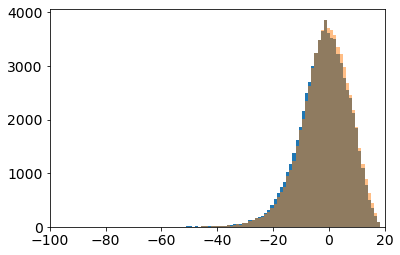

In [33]:
_ = plt.hist(dd['old_logp'],bins=400, range=(-400,50))
_ = plt.hist(dd['new_logp'],bins=400, range=(-400,50), alpha=0.5)
for jj in range(16):plt.xlim(-100,20)

In [43]:
for dd in [train,valid,test]:
    dd['new_inf_labels'] = np.asarray(dd['new_inf_labels'], dtype=int)

In [44]:
trees = []
for jj in range(16):
    enc              = encoded_train[(train['new_label']==jj)&(train['new_inf_labels']==jj)]
    print(len(enc))
    trees.append(scipy.spatial.KDTree(enc))

88474
1606
3048
352
11186
26
43677
245
48
951
93
227
25
1241
14
112


GAL NO SUBCLASS NOT BROADLINE


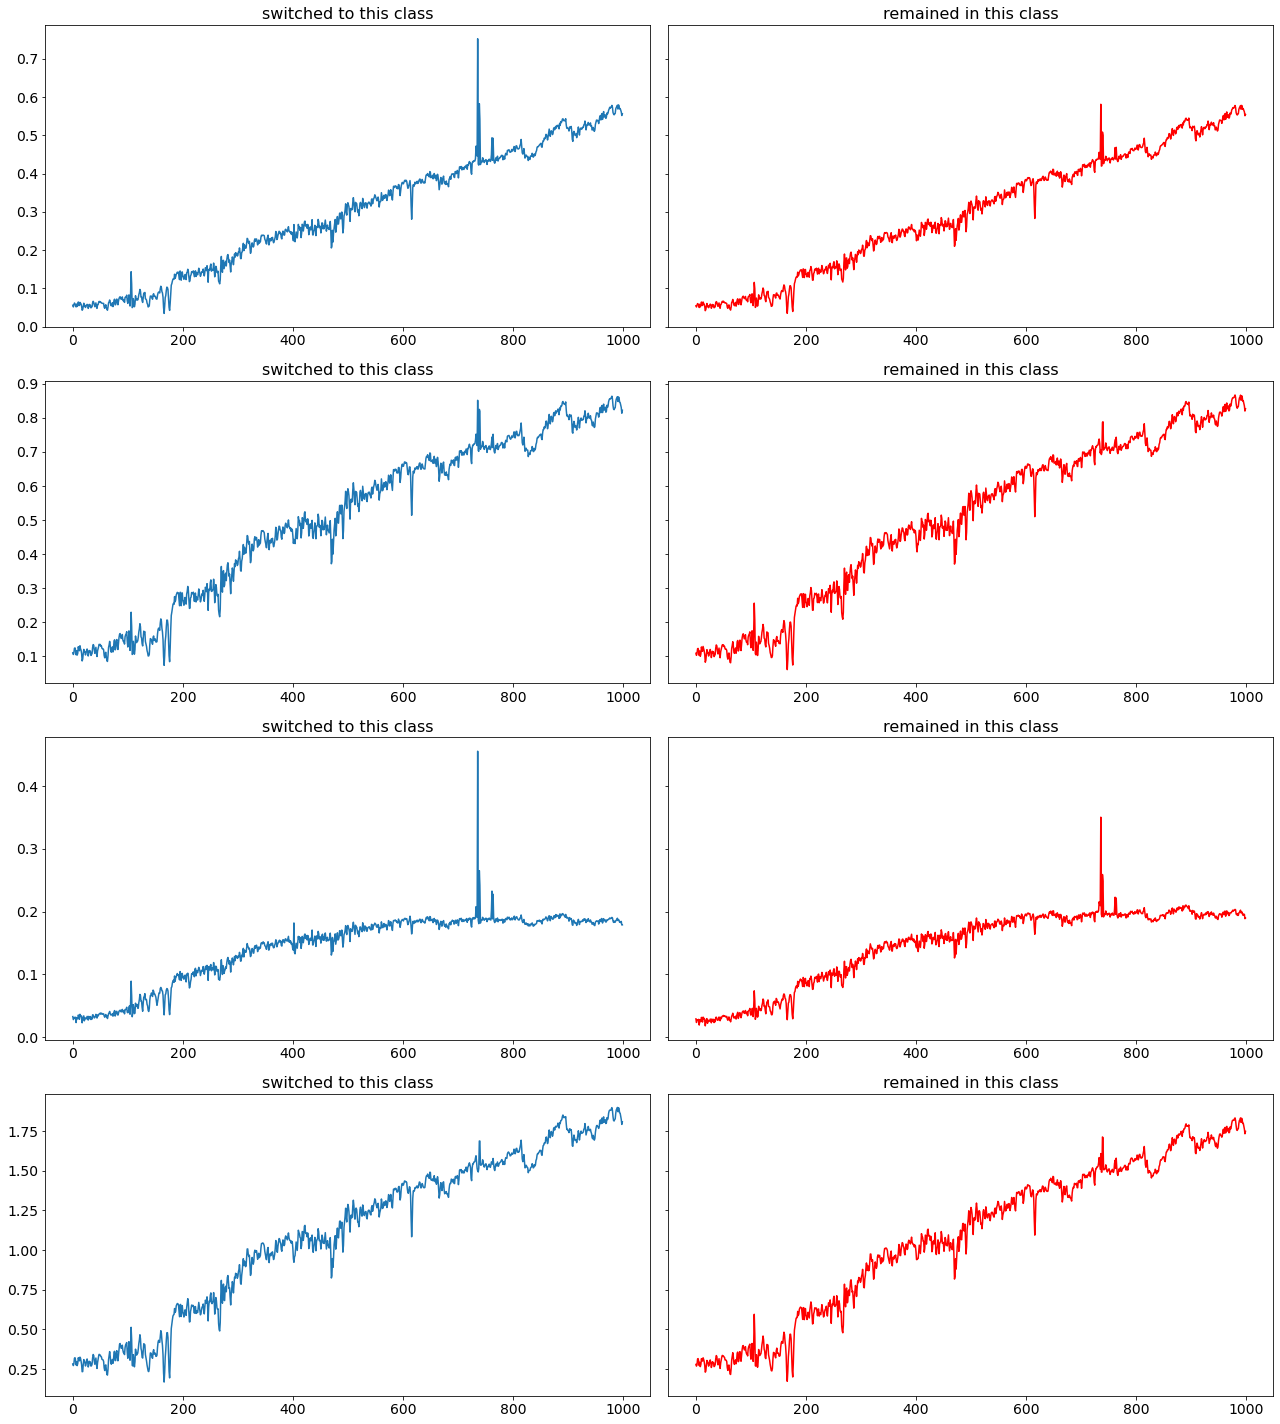

GAL NO SUBCLASS BROADLINE


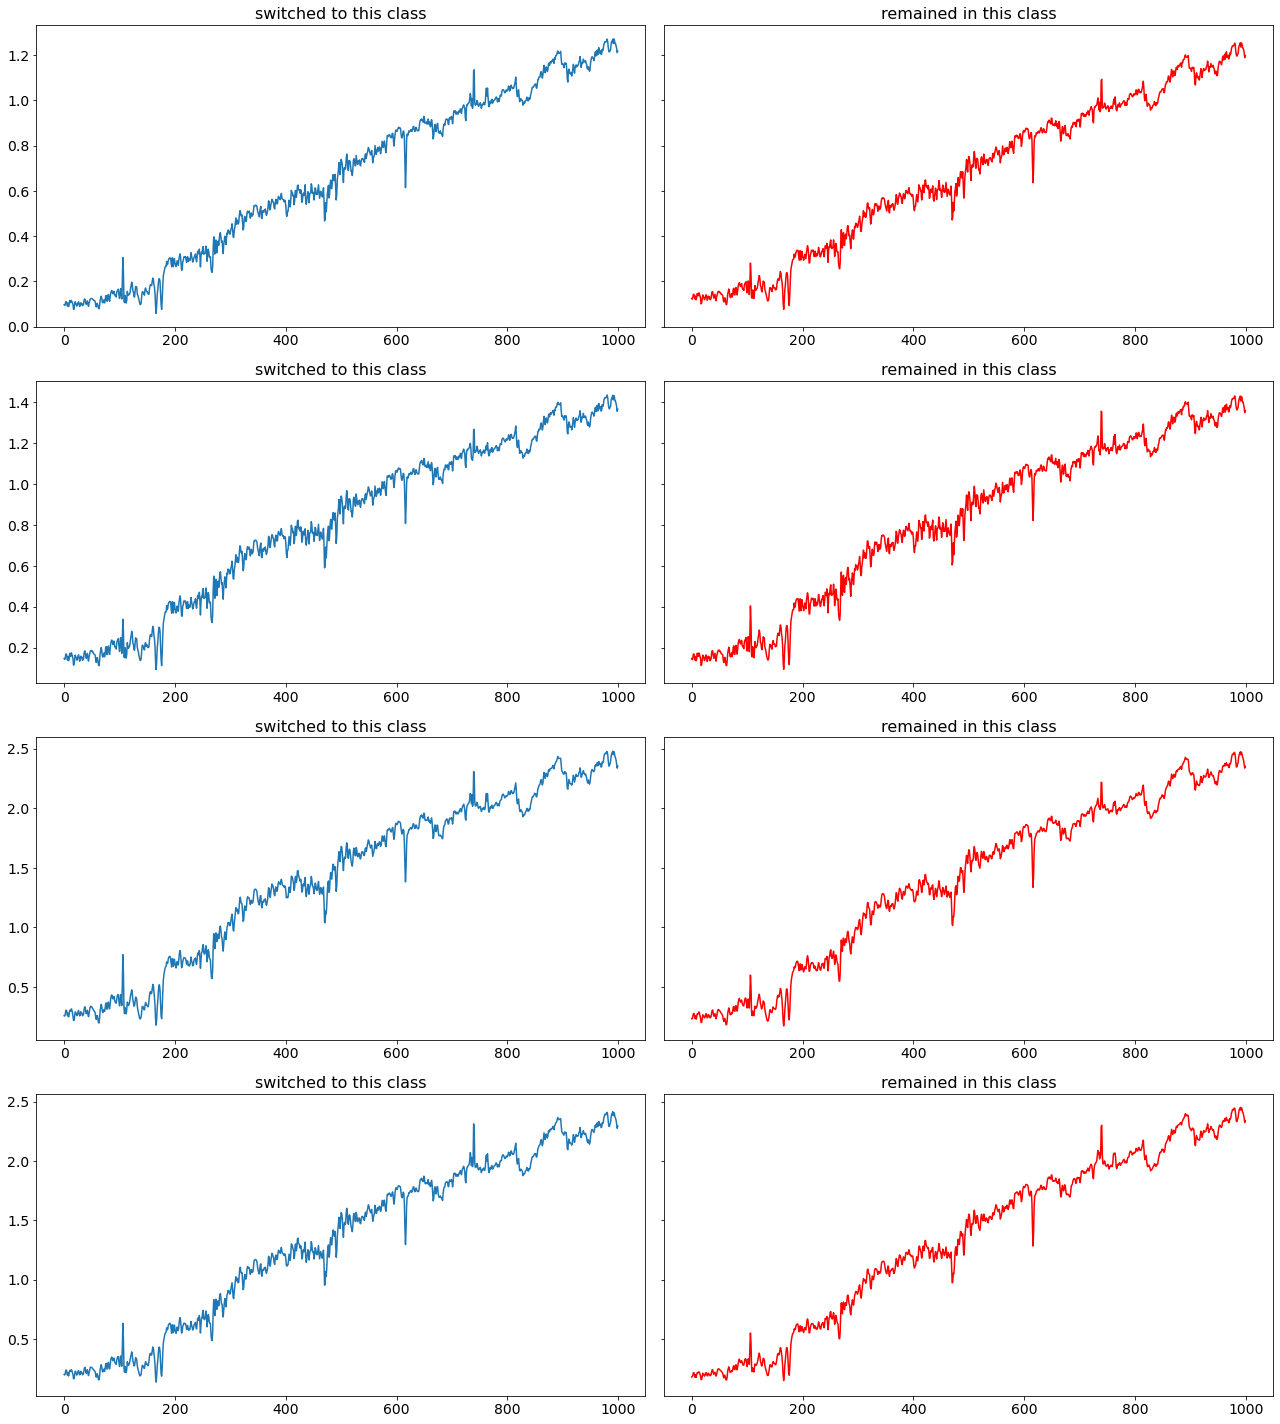

GAL AGN NOT BROADLINE


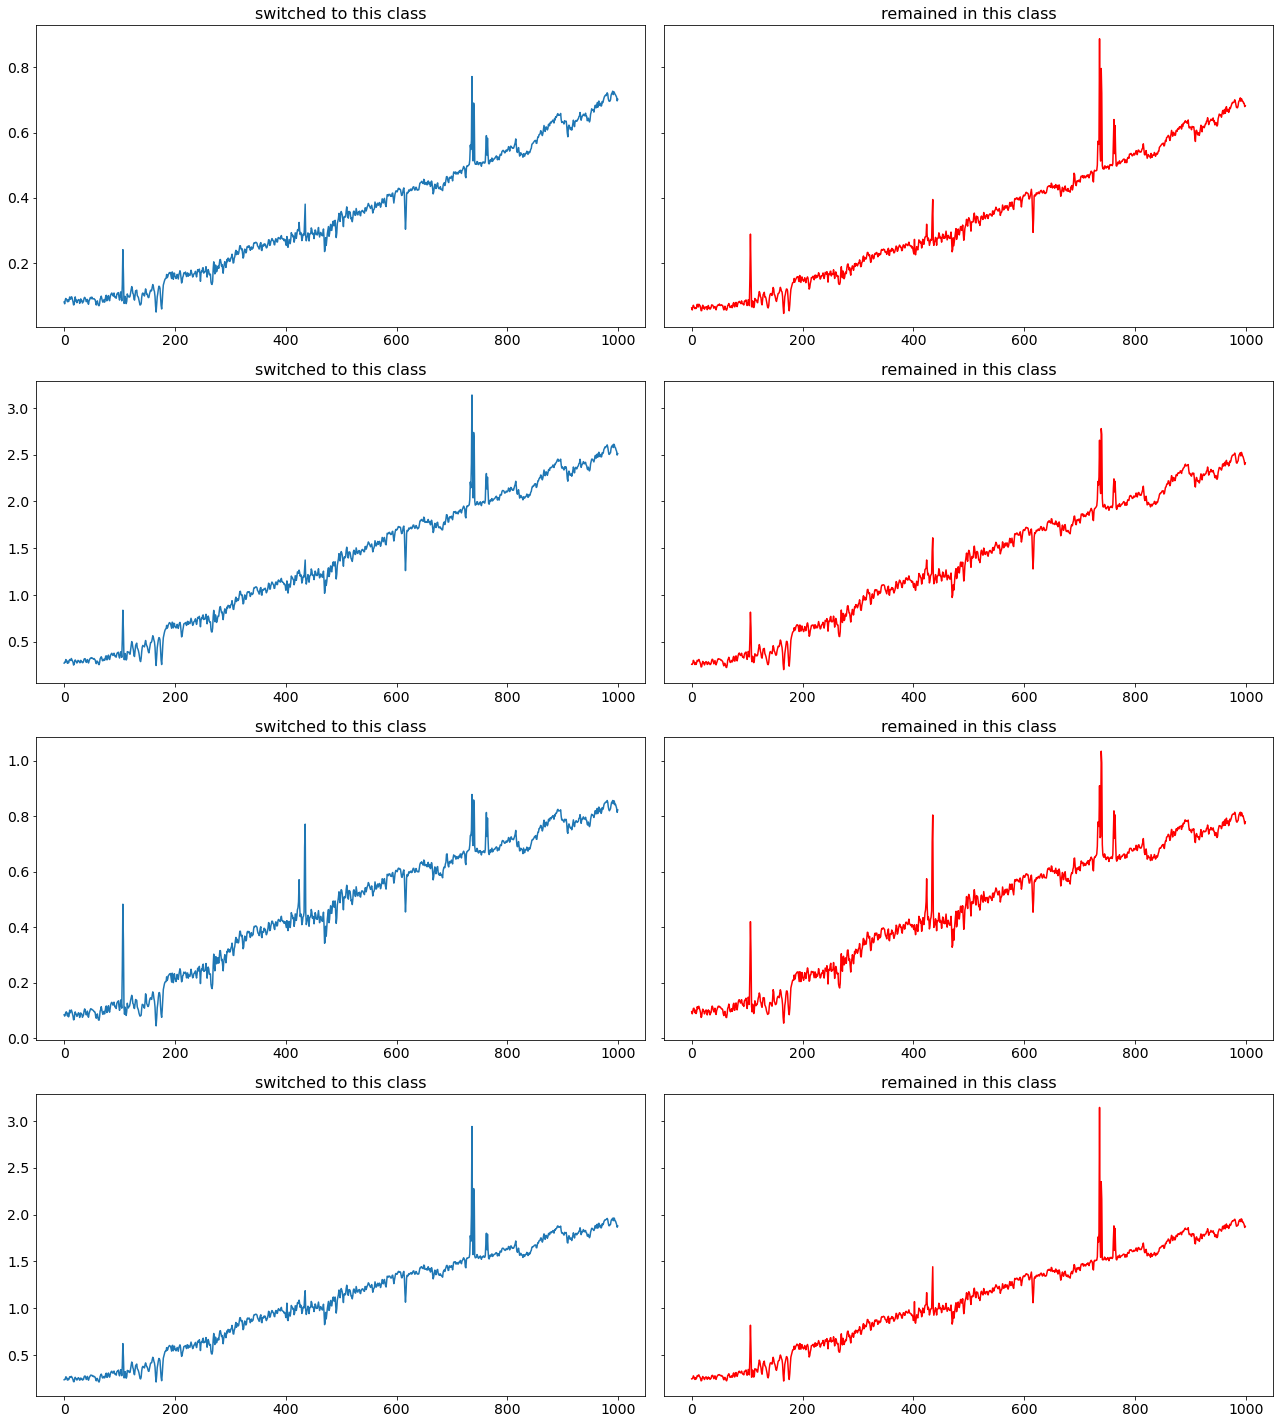

GAL AGN BROADLINE


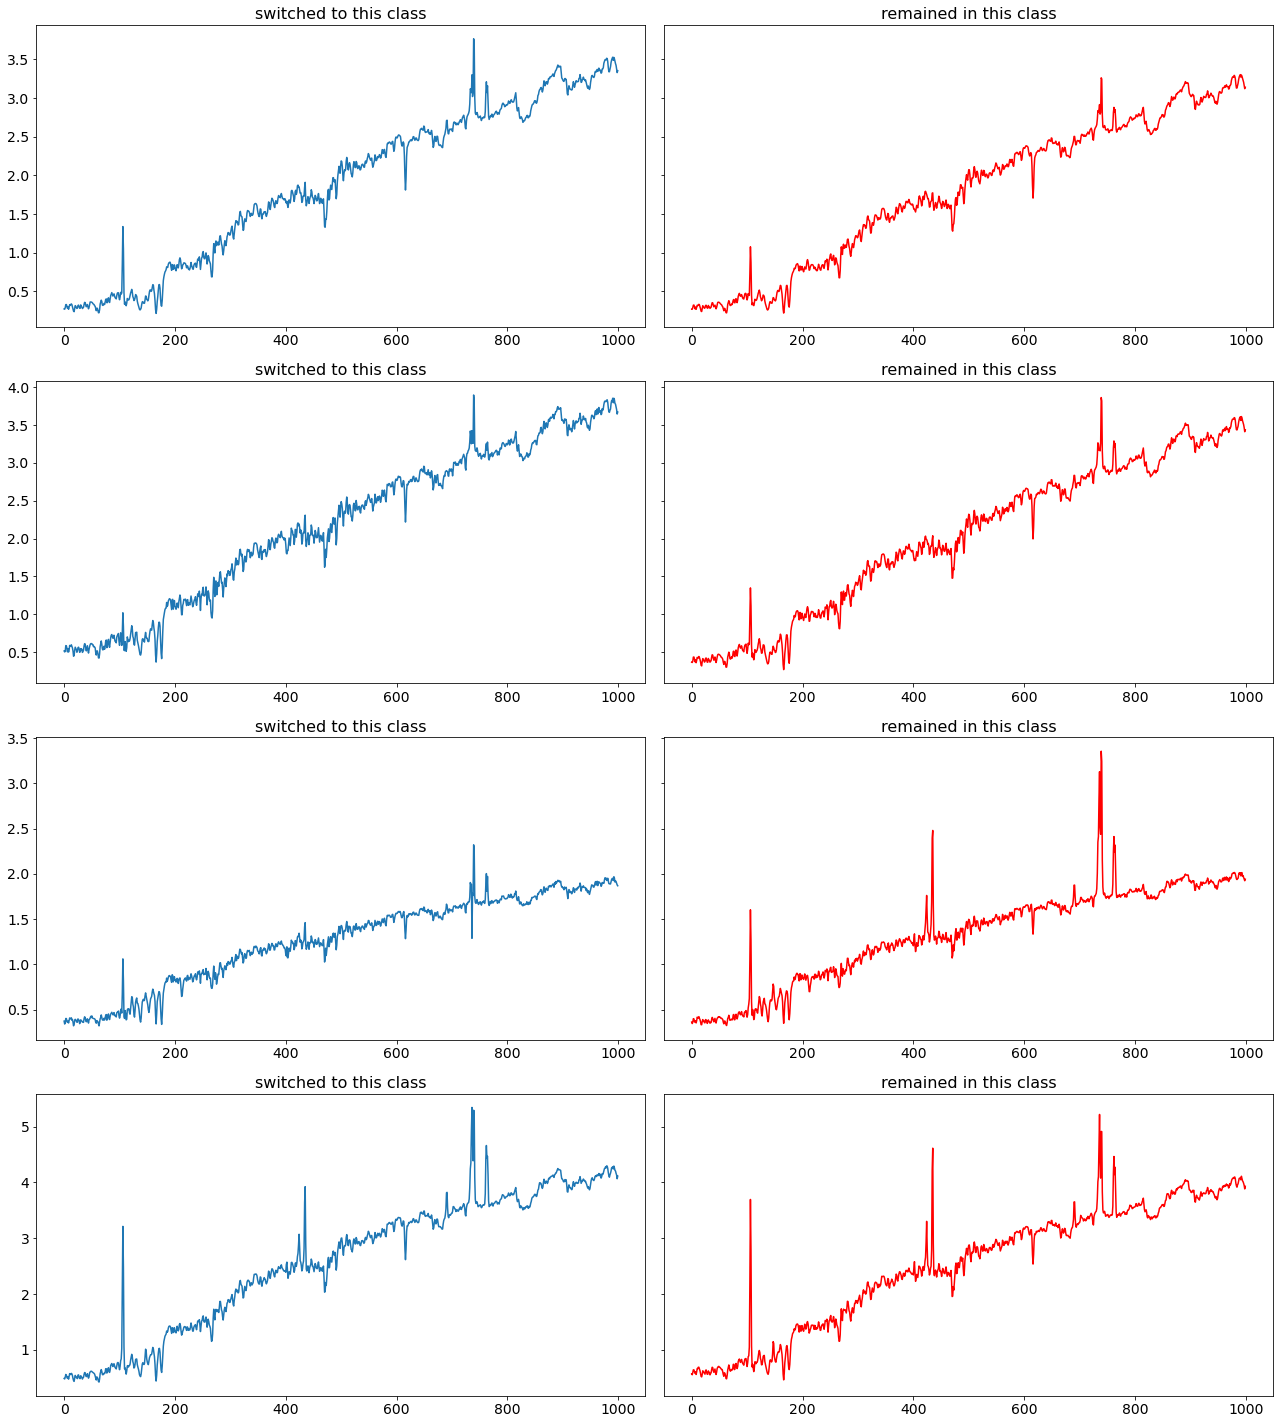

GAL STARBURST NOT BROADLINE


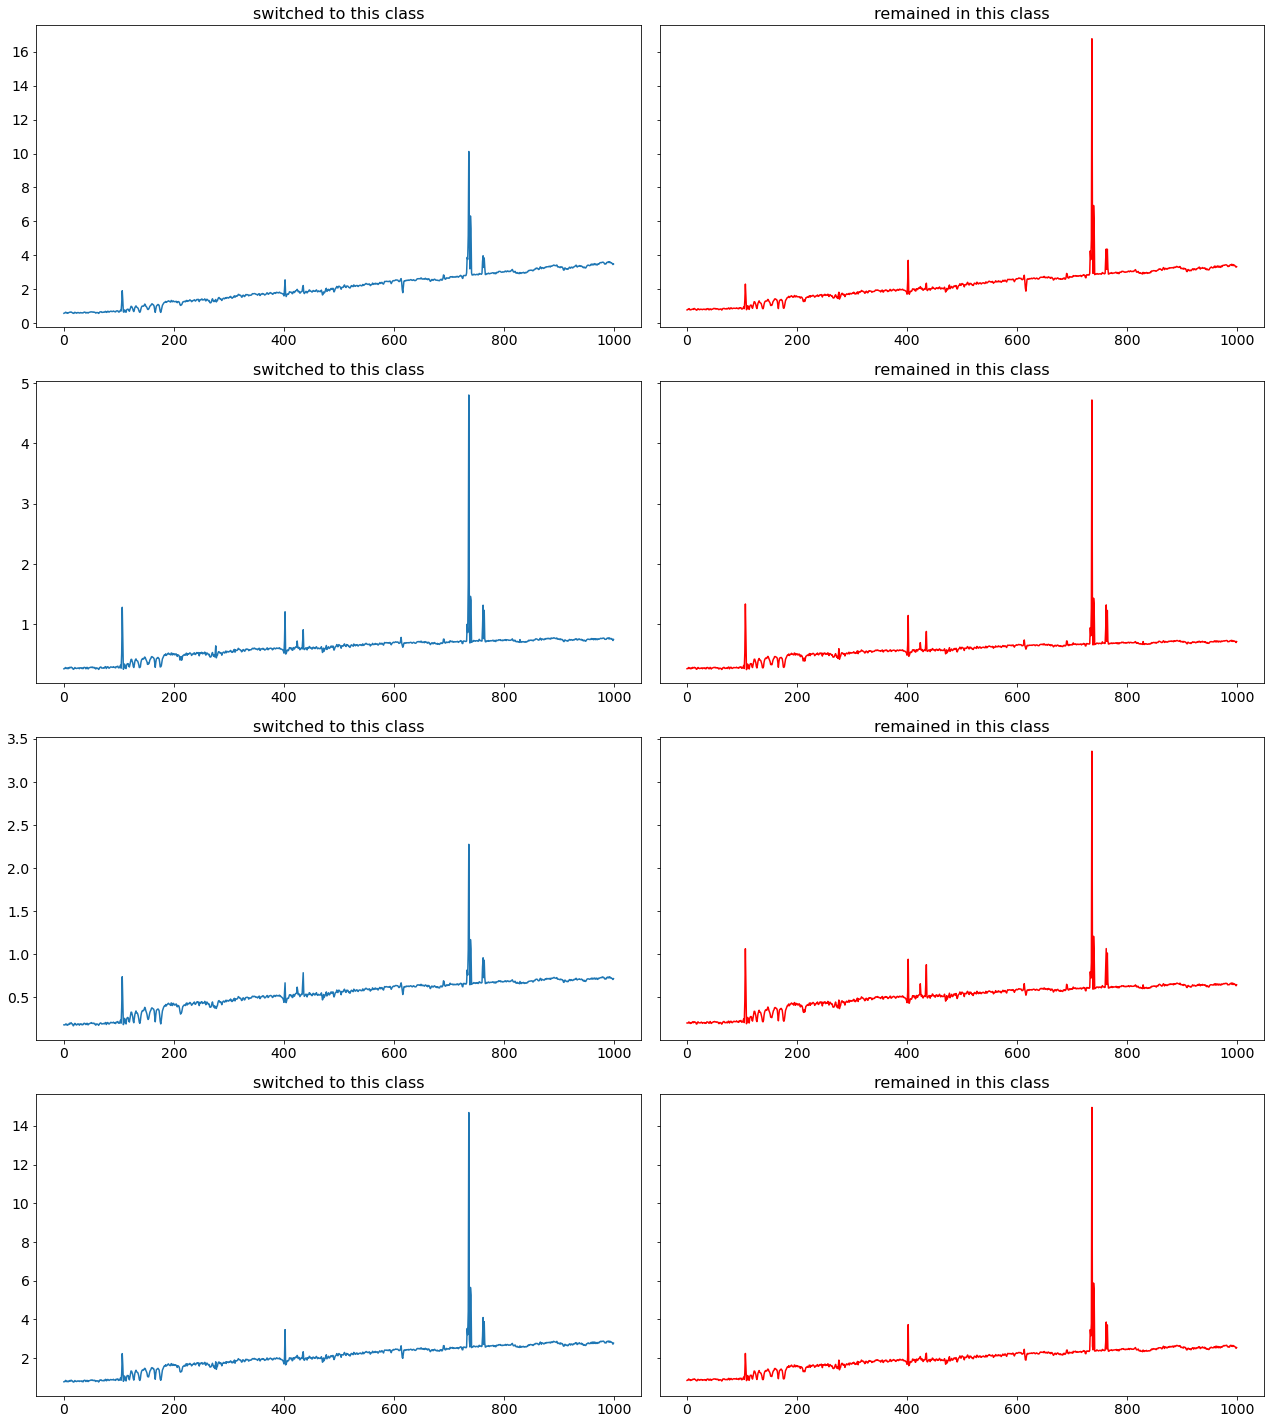

GAL STARBURST BROADLINE


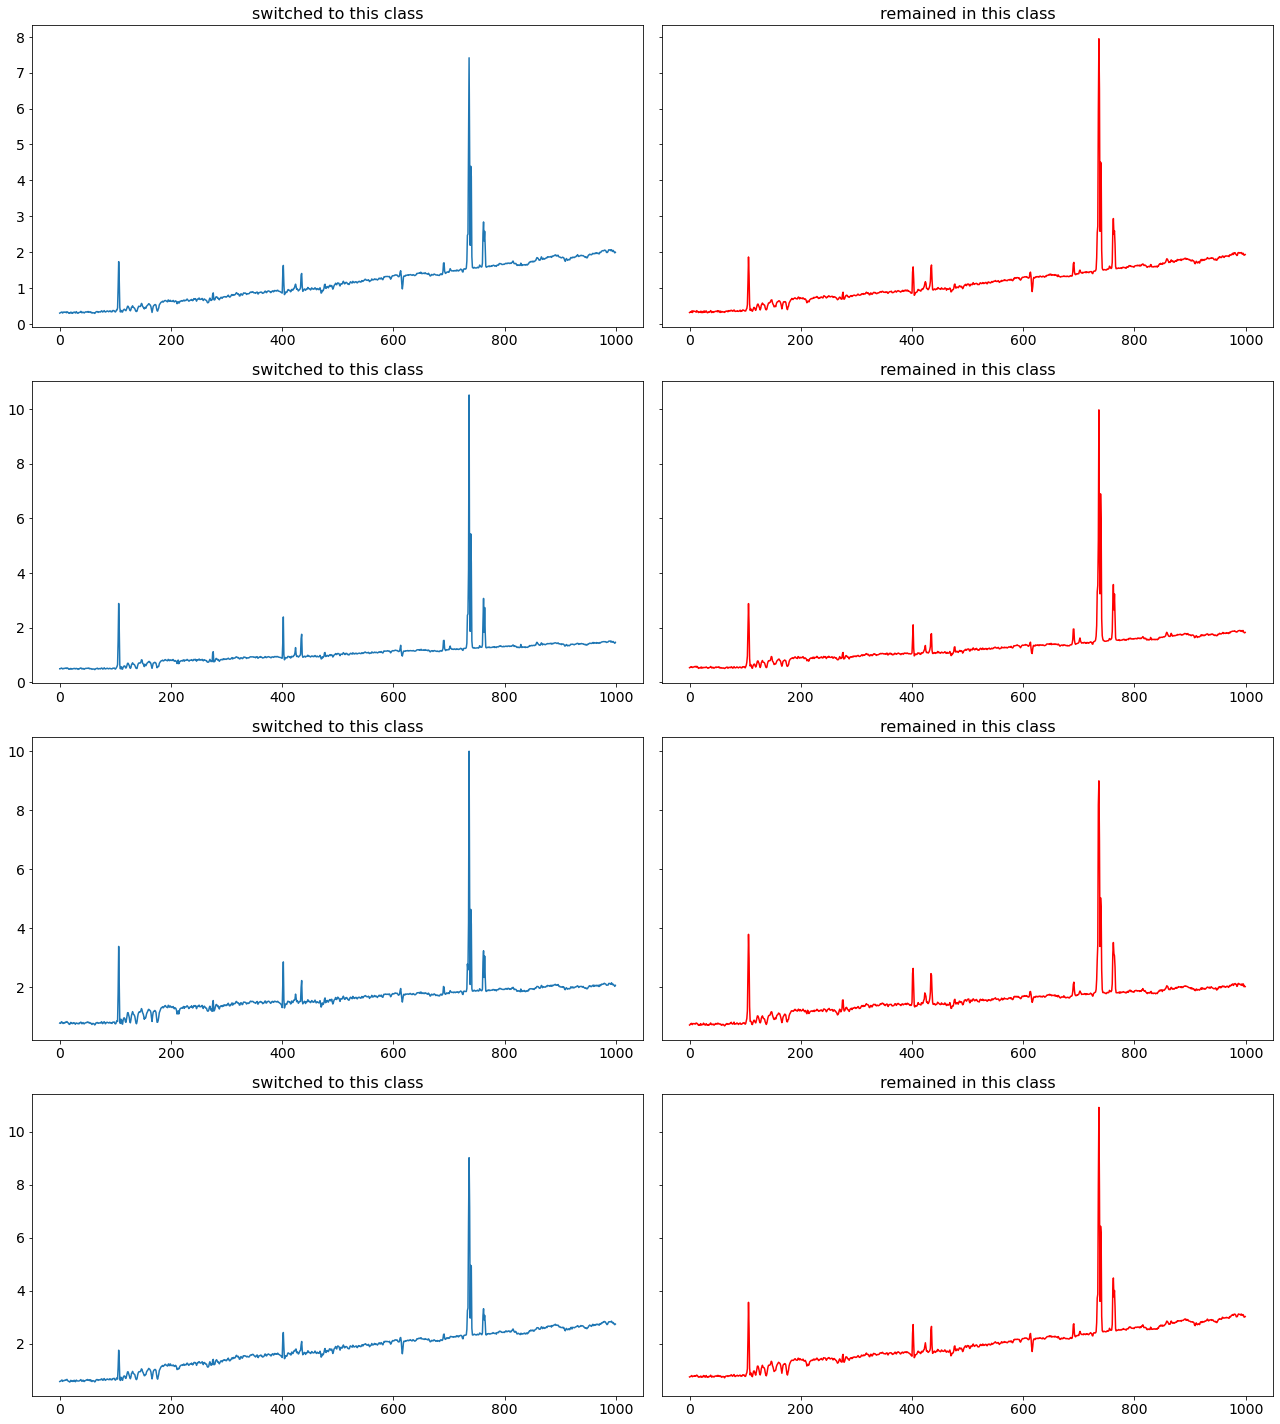

GAL STARFORMING NOT BROADLINE


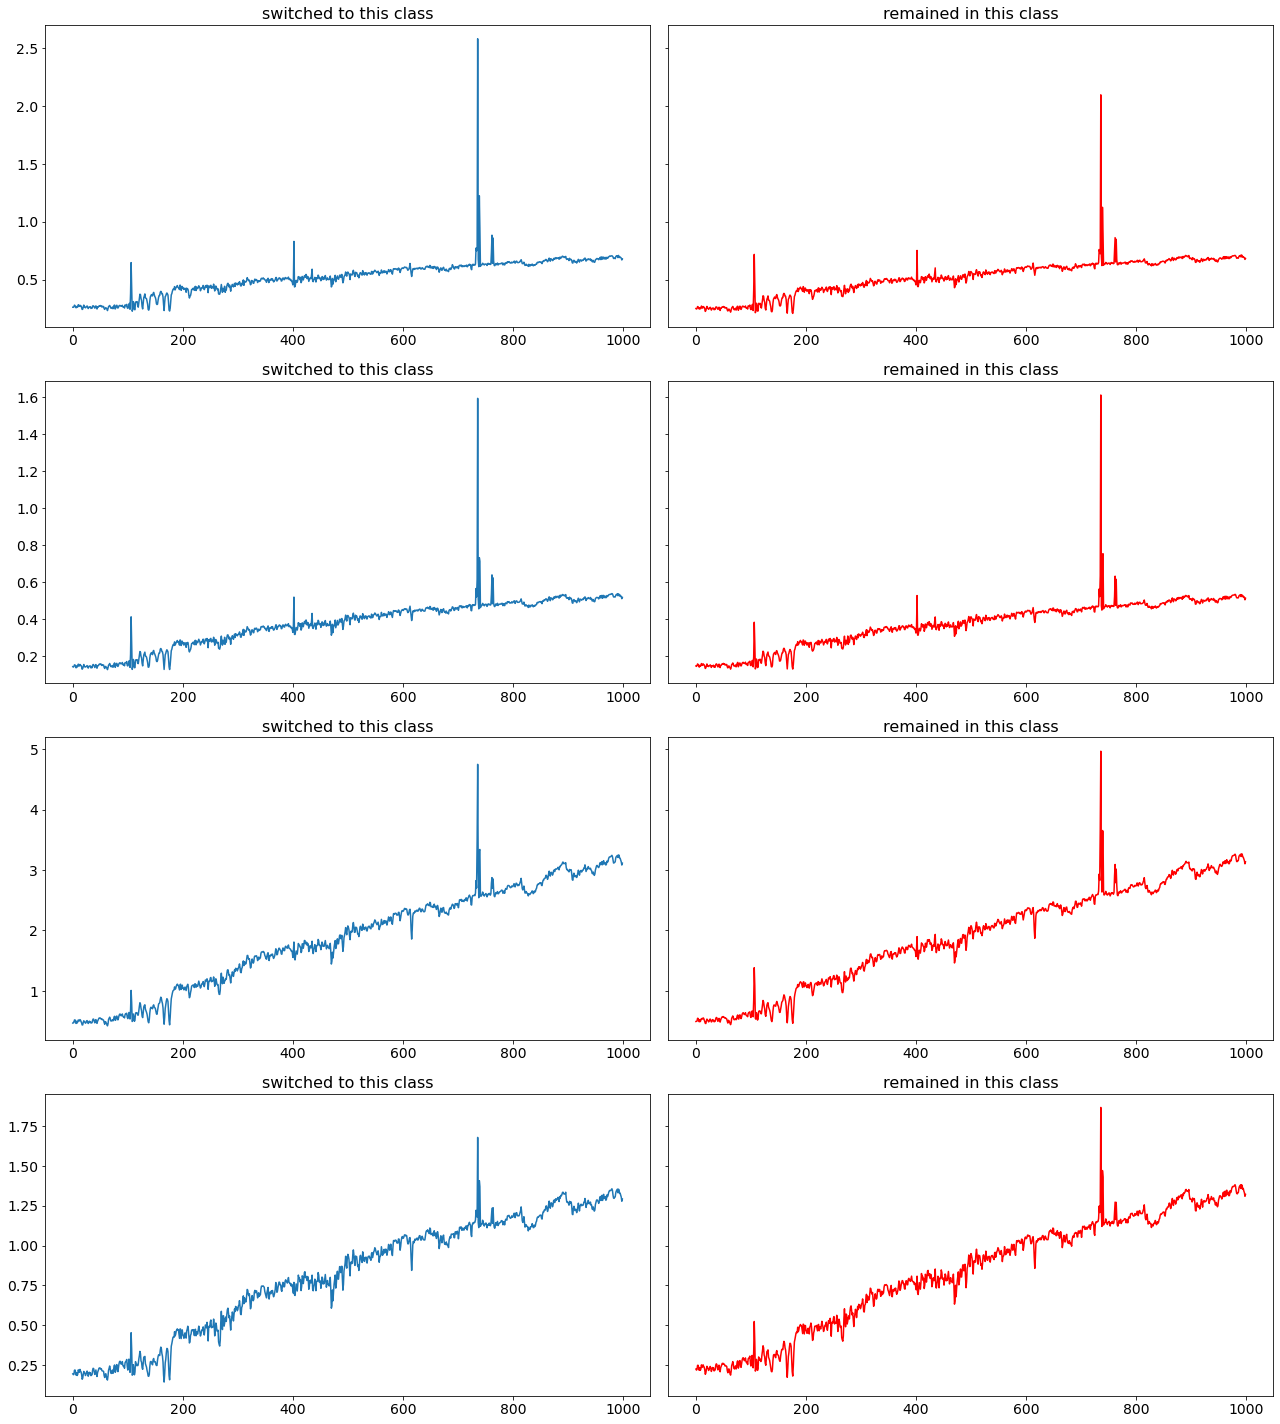

GAL STARFORMING BROADLINE


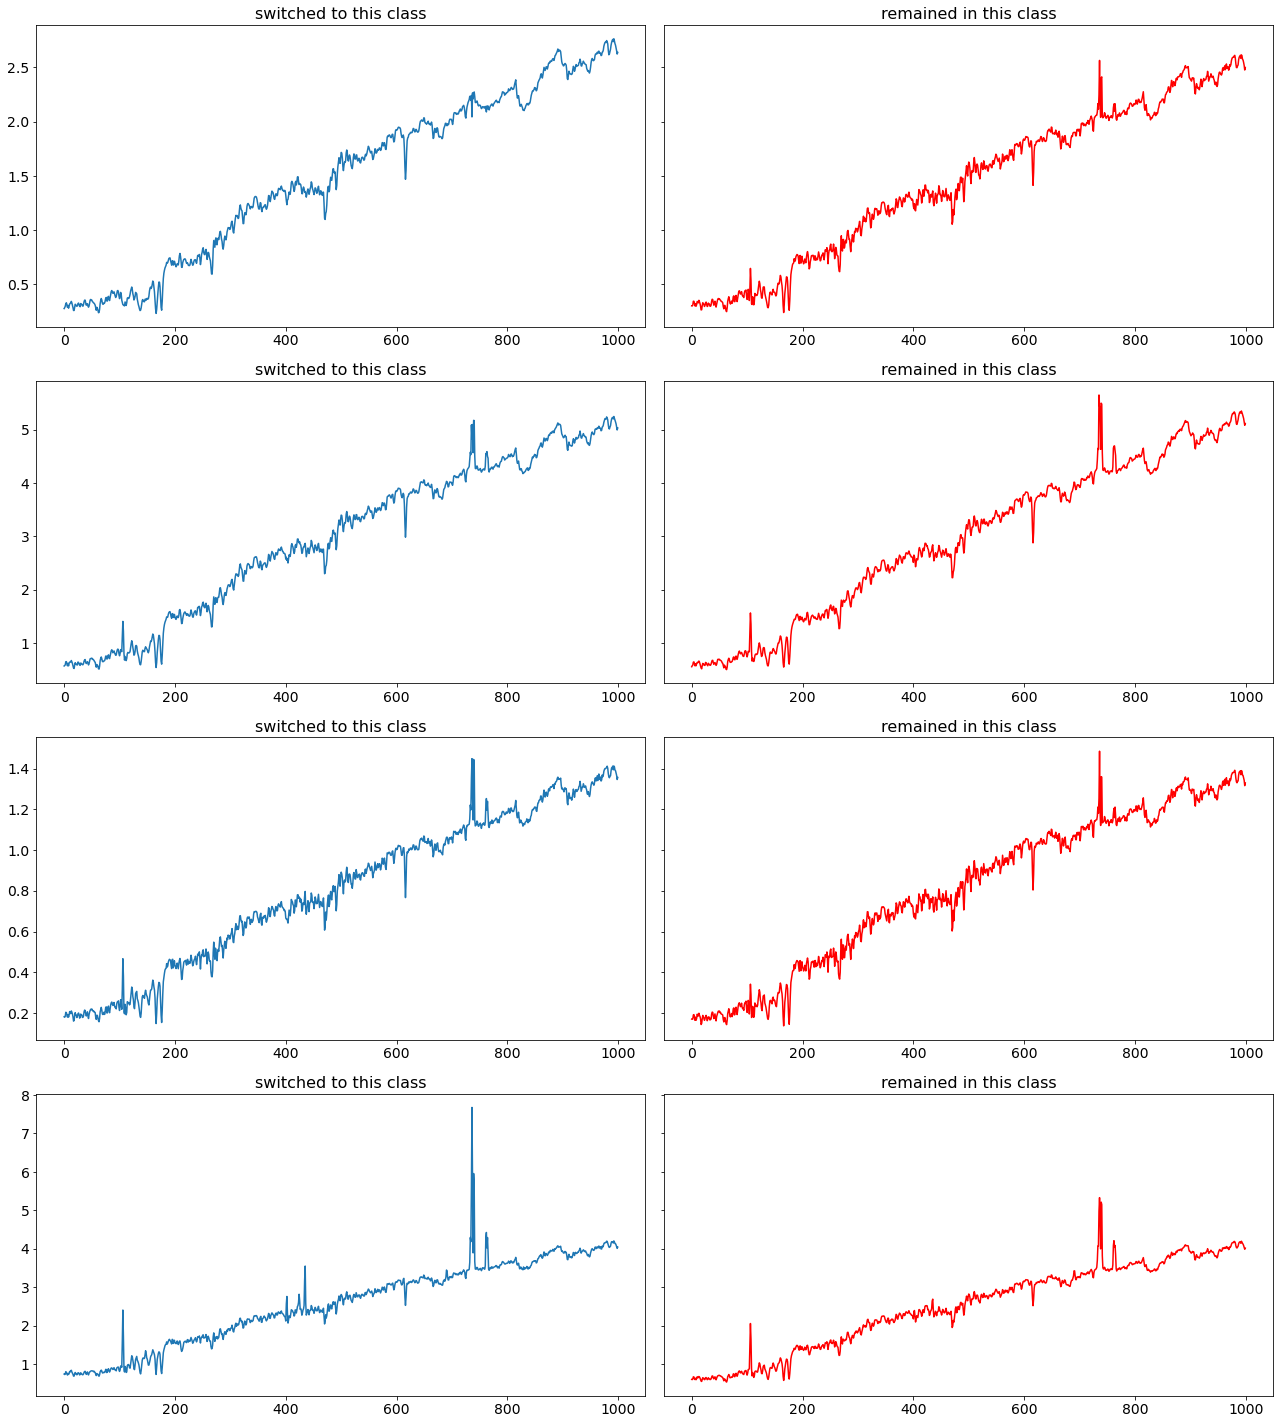

QSO NO SUBCLASS NOT BROADLINE


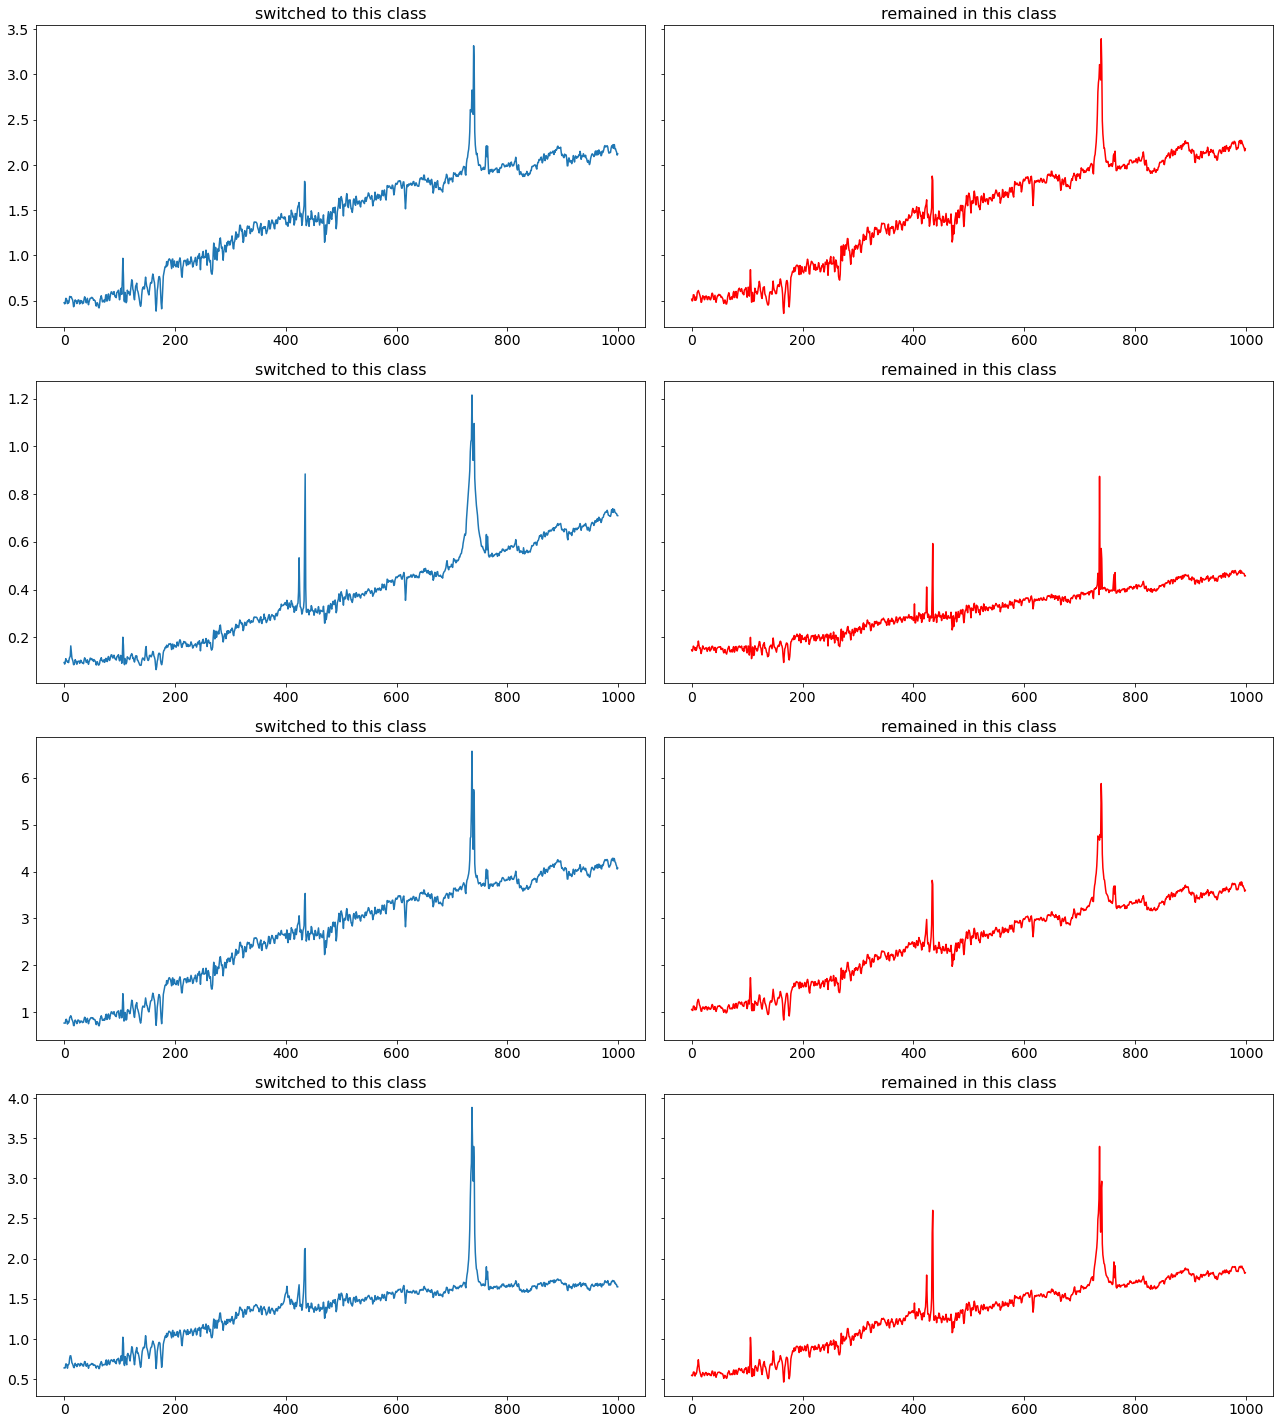

QSO NO SUBCLASS BROADLINE


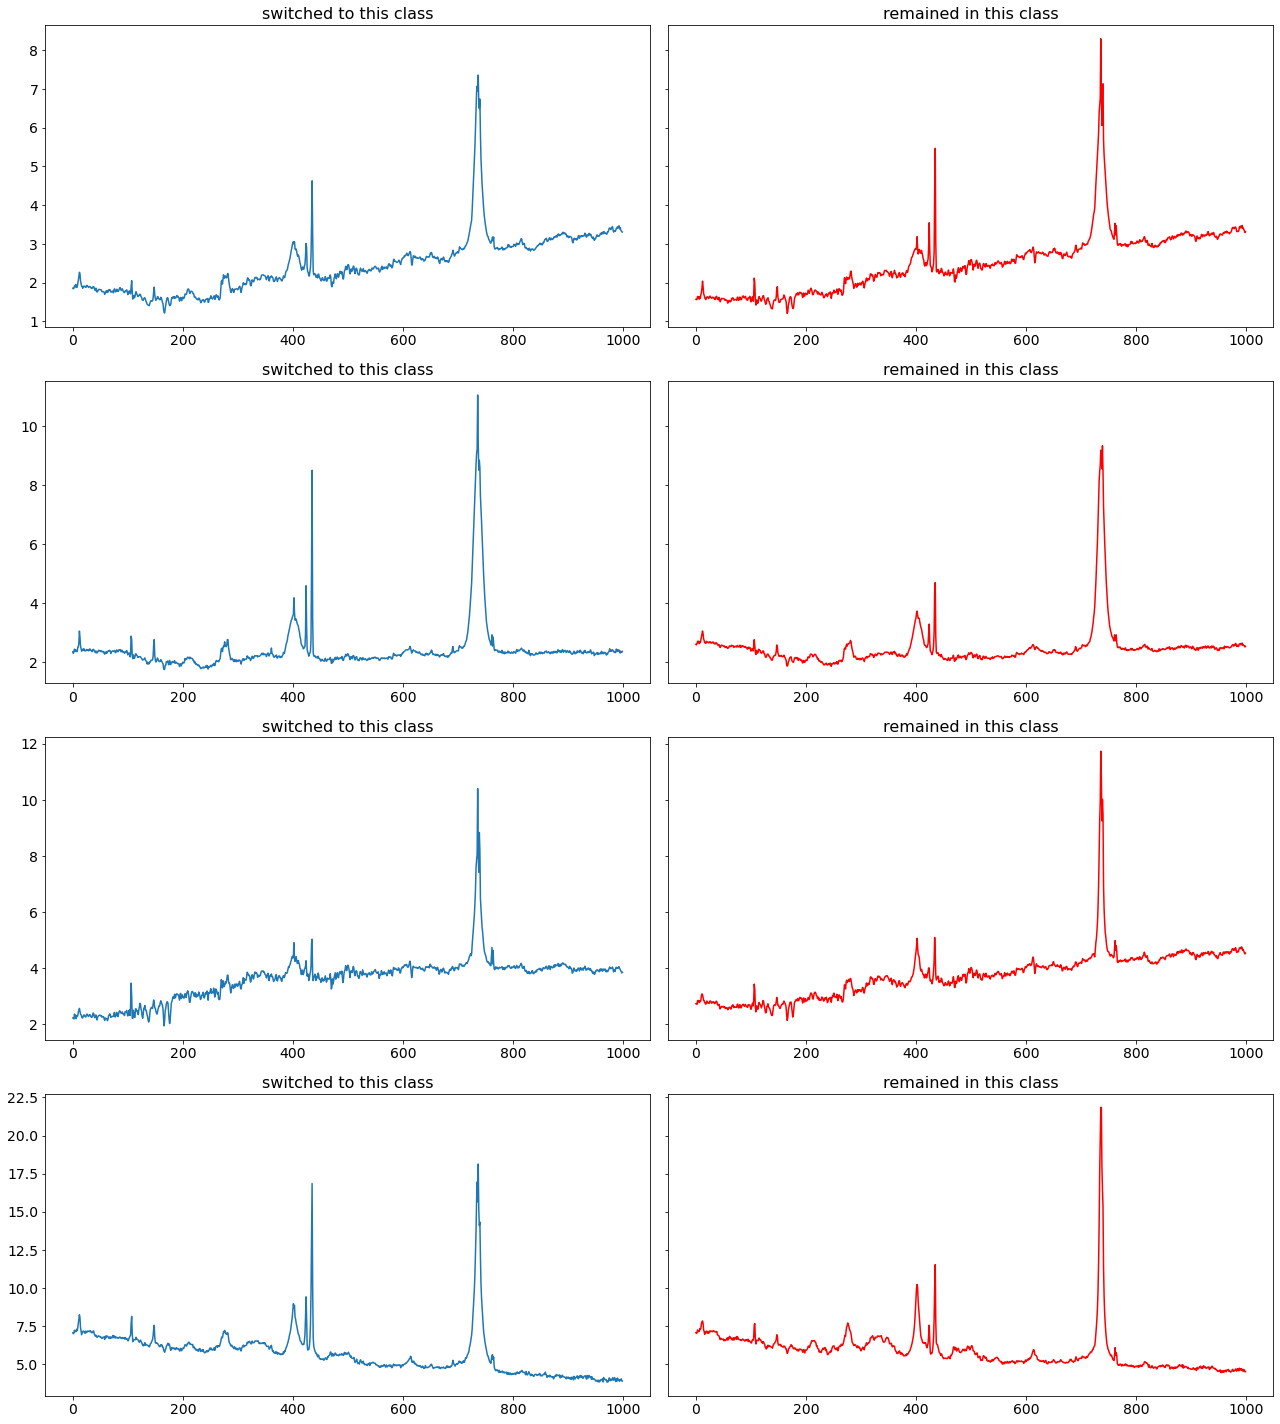

QSO AGN NOT BROADLINE


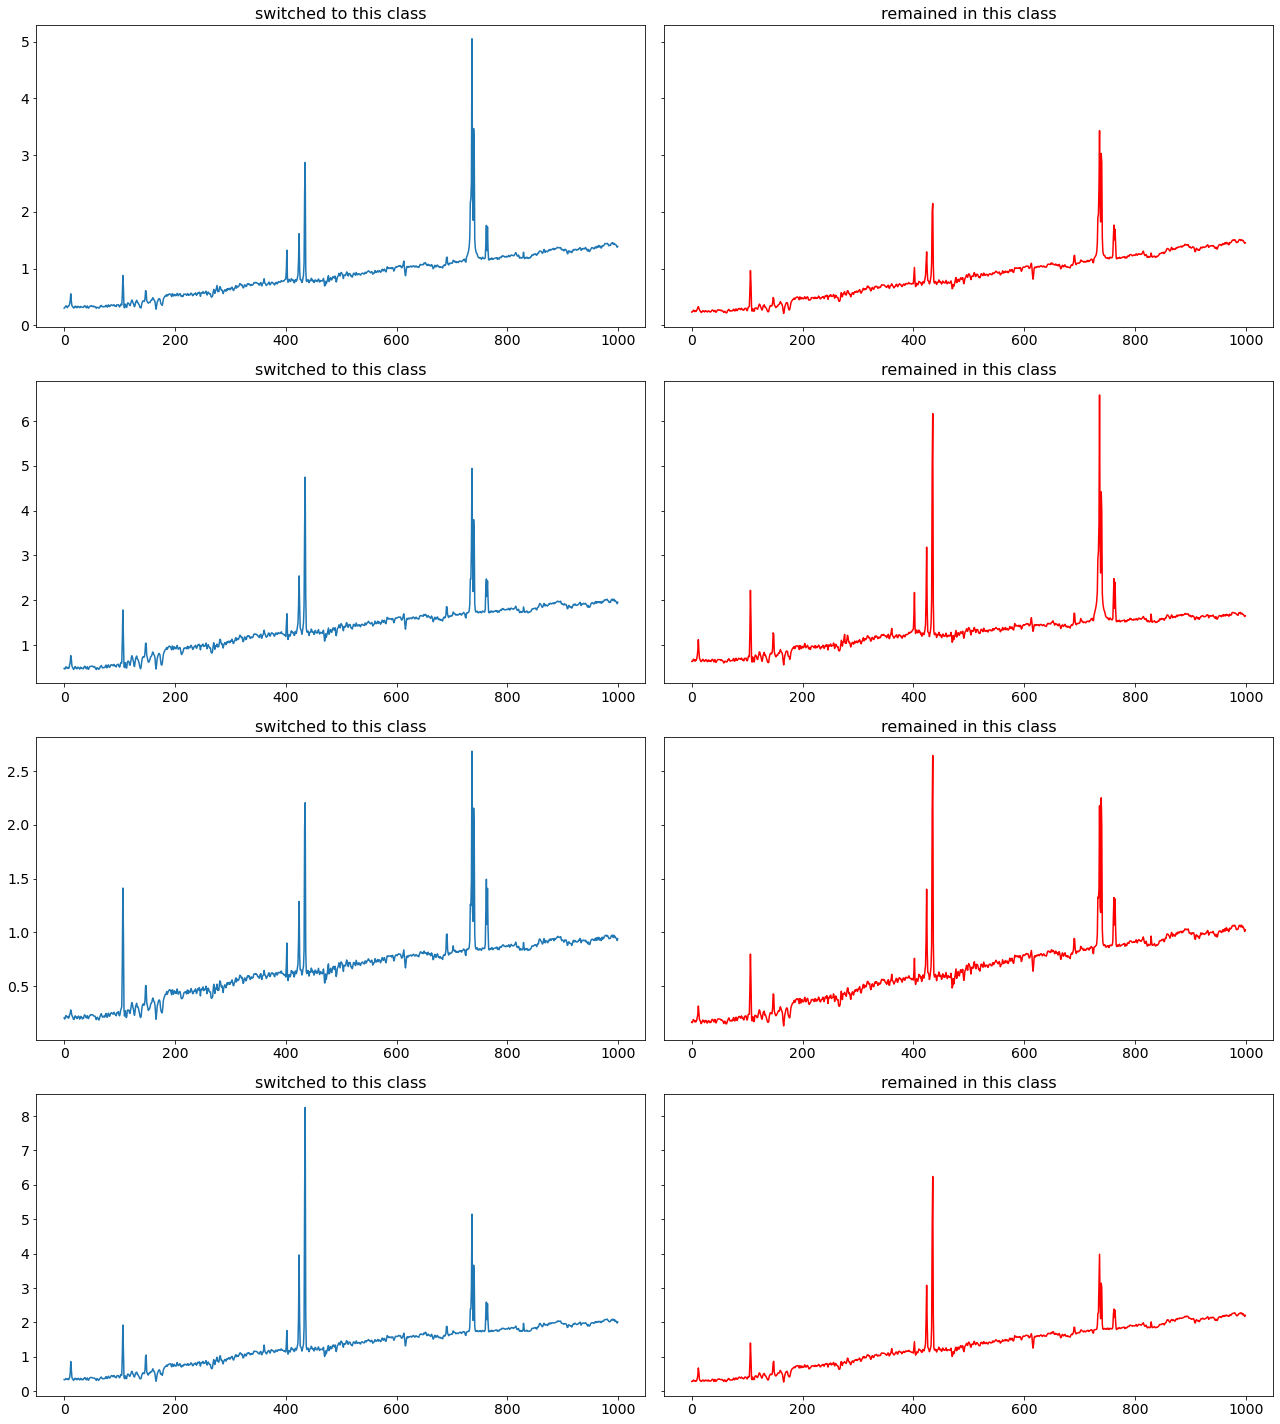

QSO AGN BROADLINE


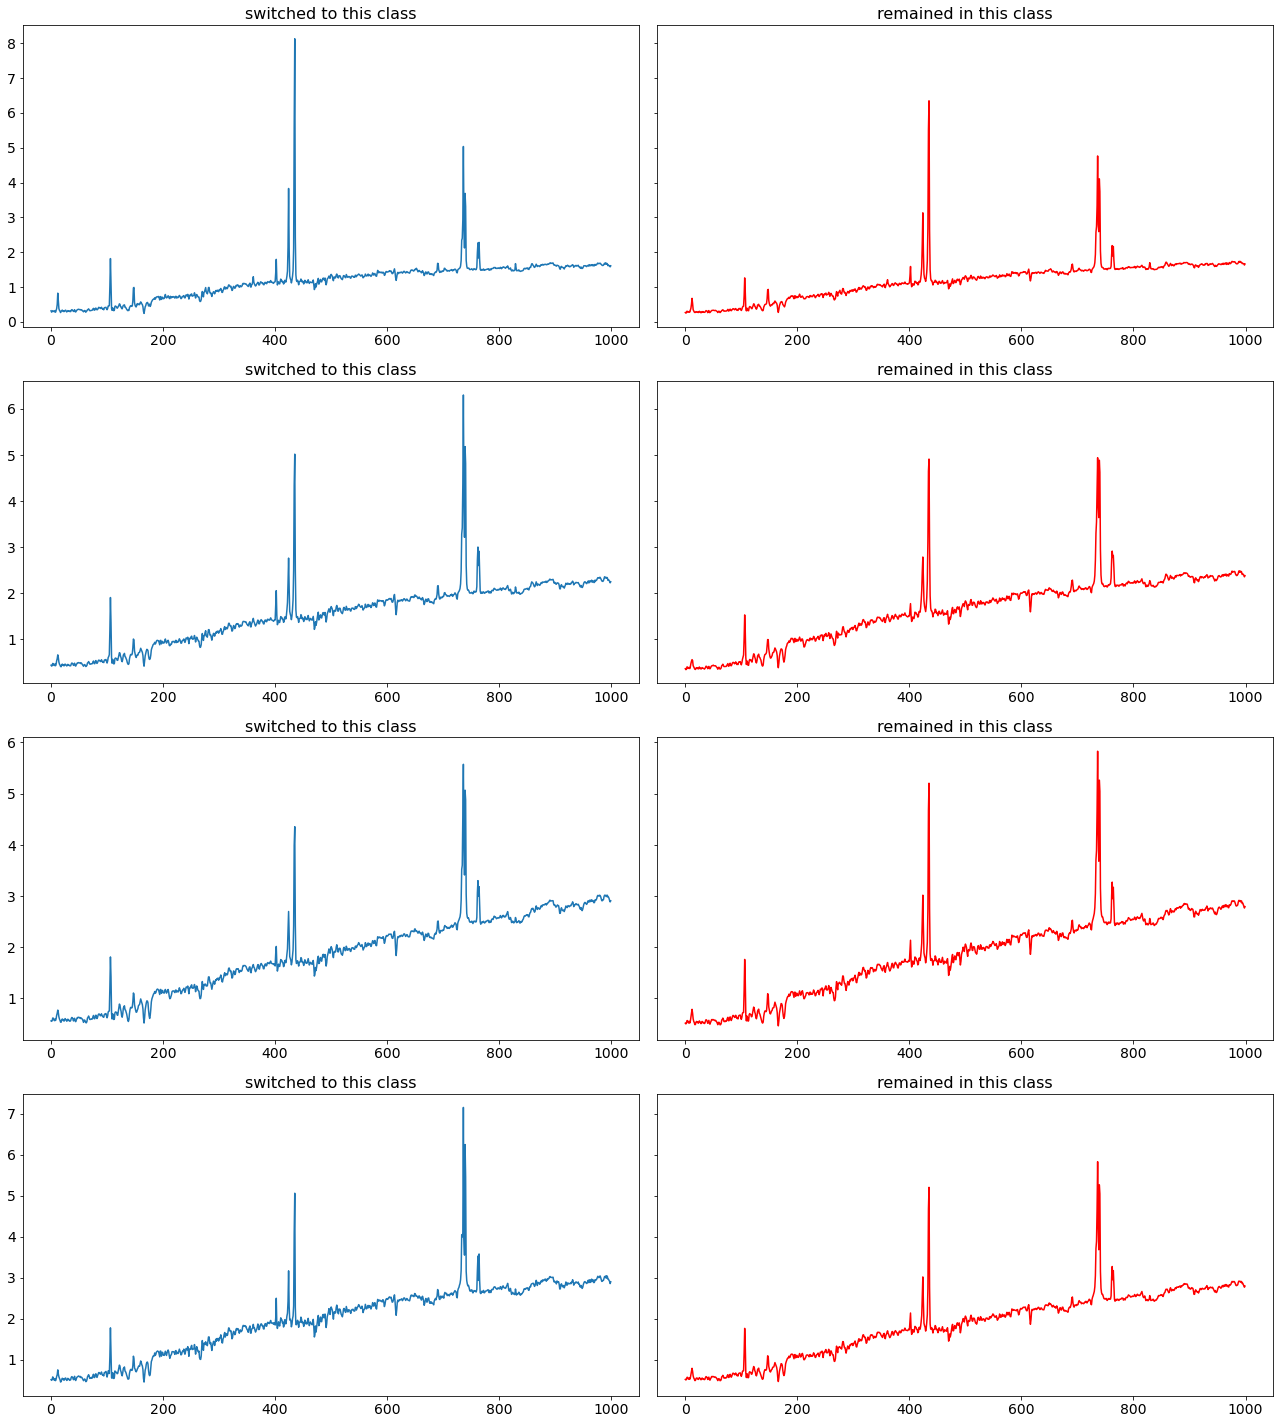

QSO STARBURST NOT BROADLINE


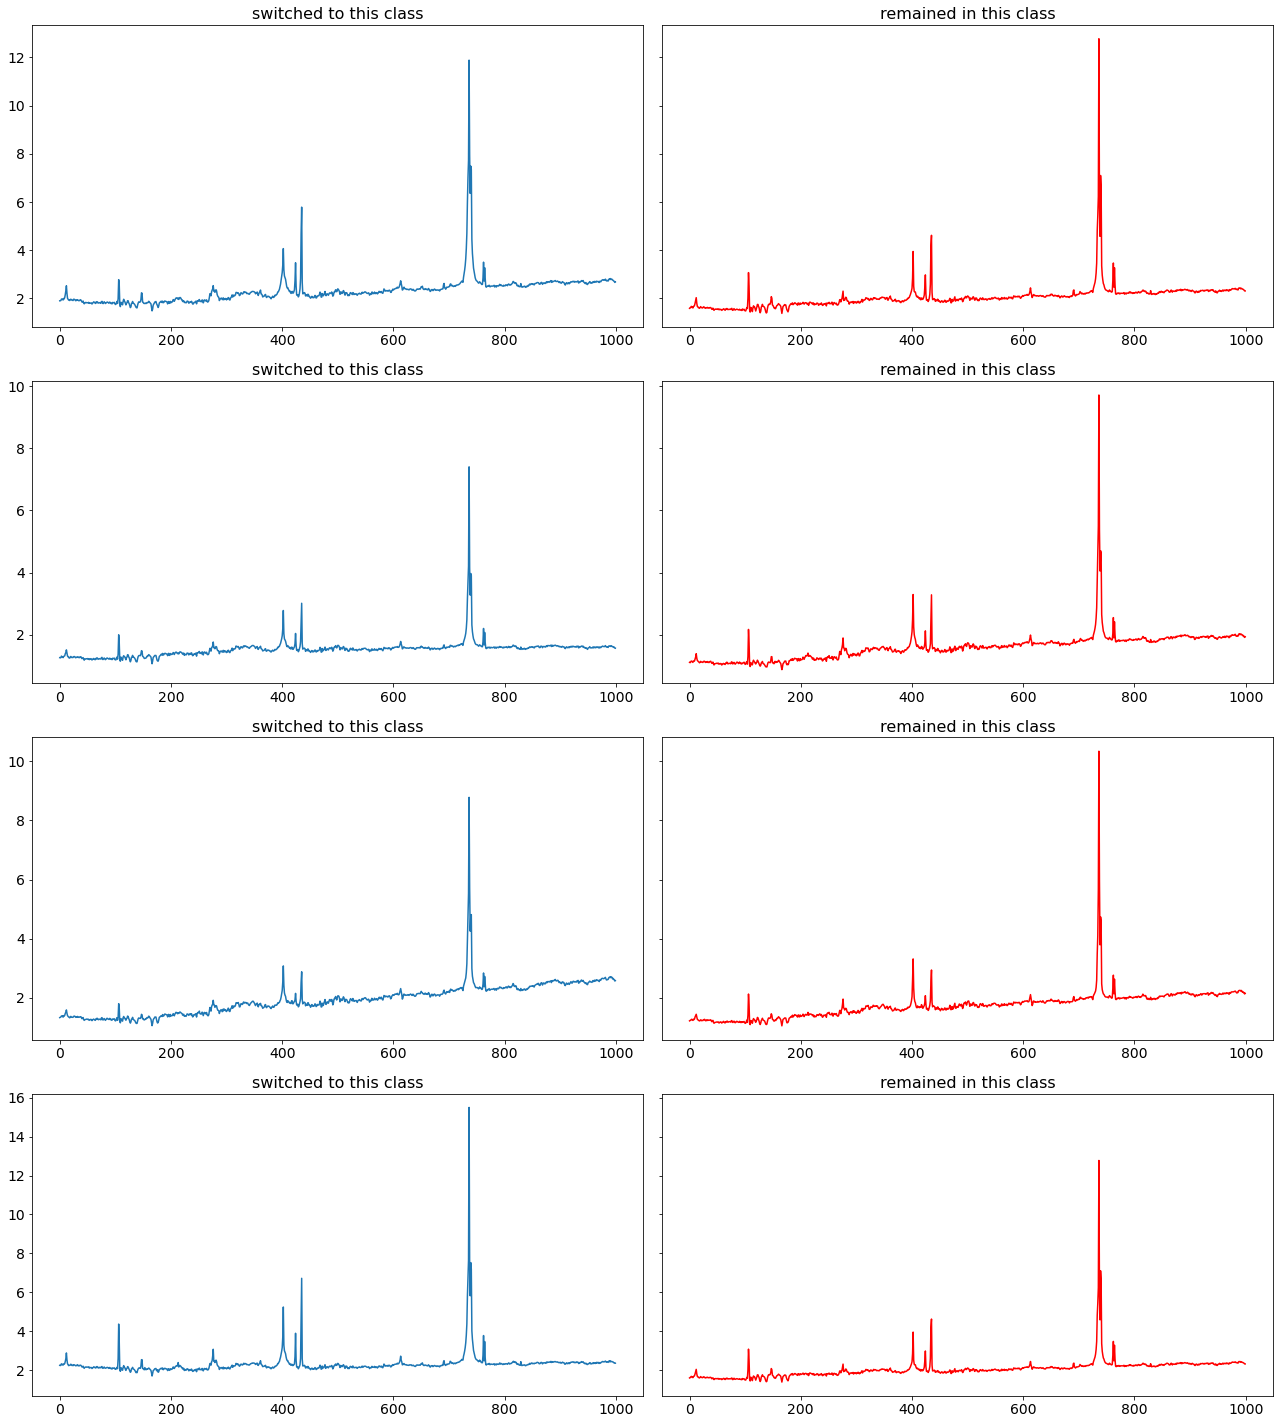

QSO STARBURST BROADLINE


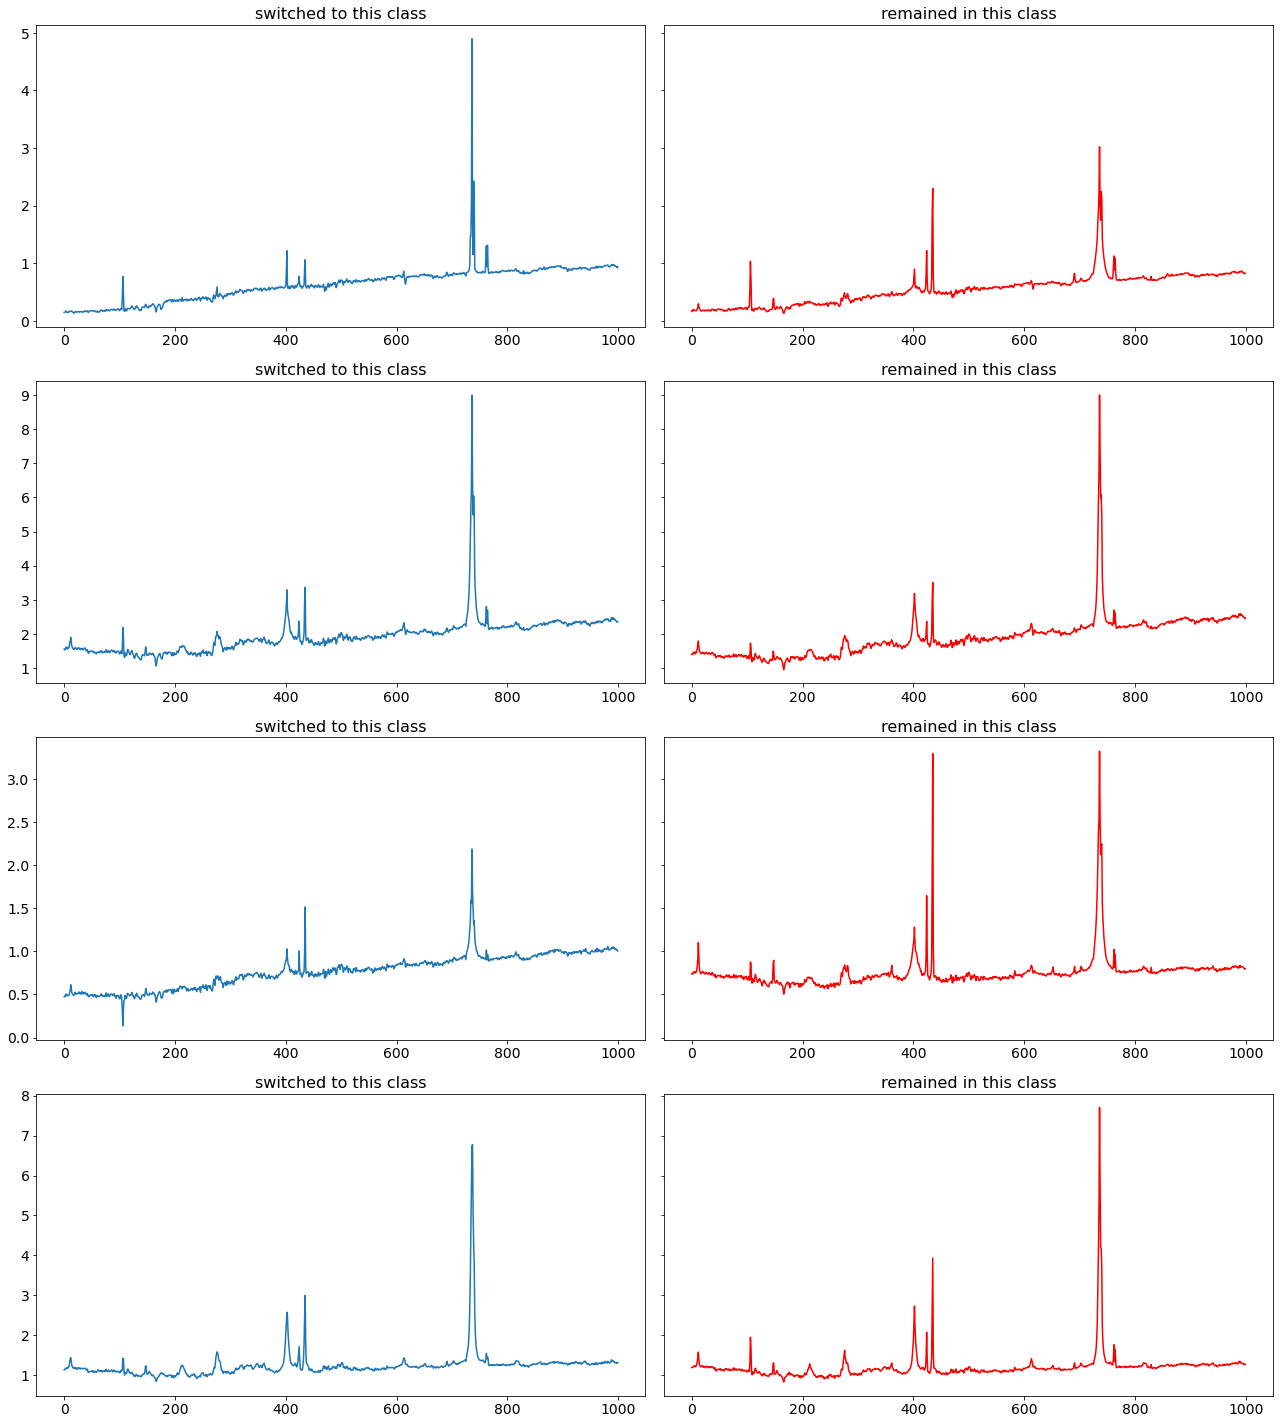

QSO STARFORMING NOT BROADLINE


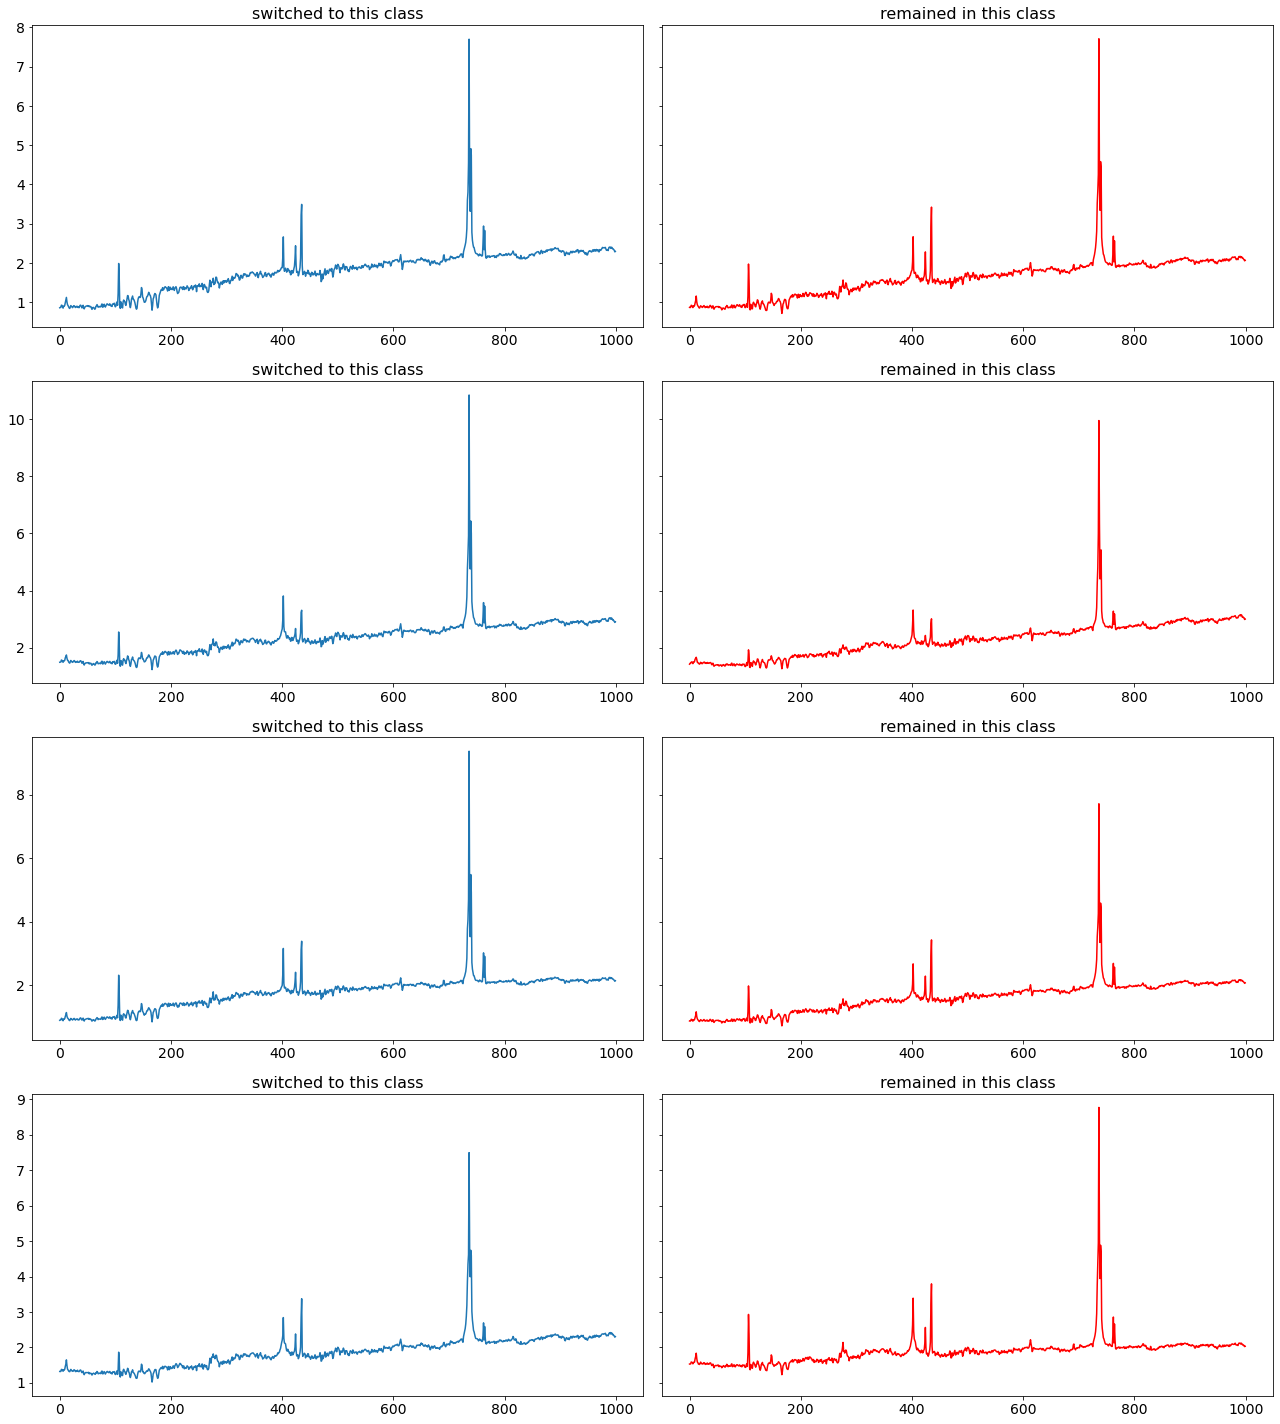

QSO STARFORMING BROADLINE


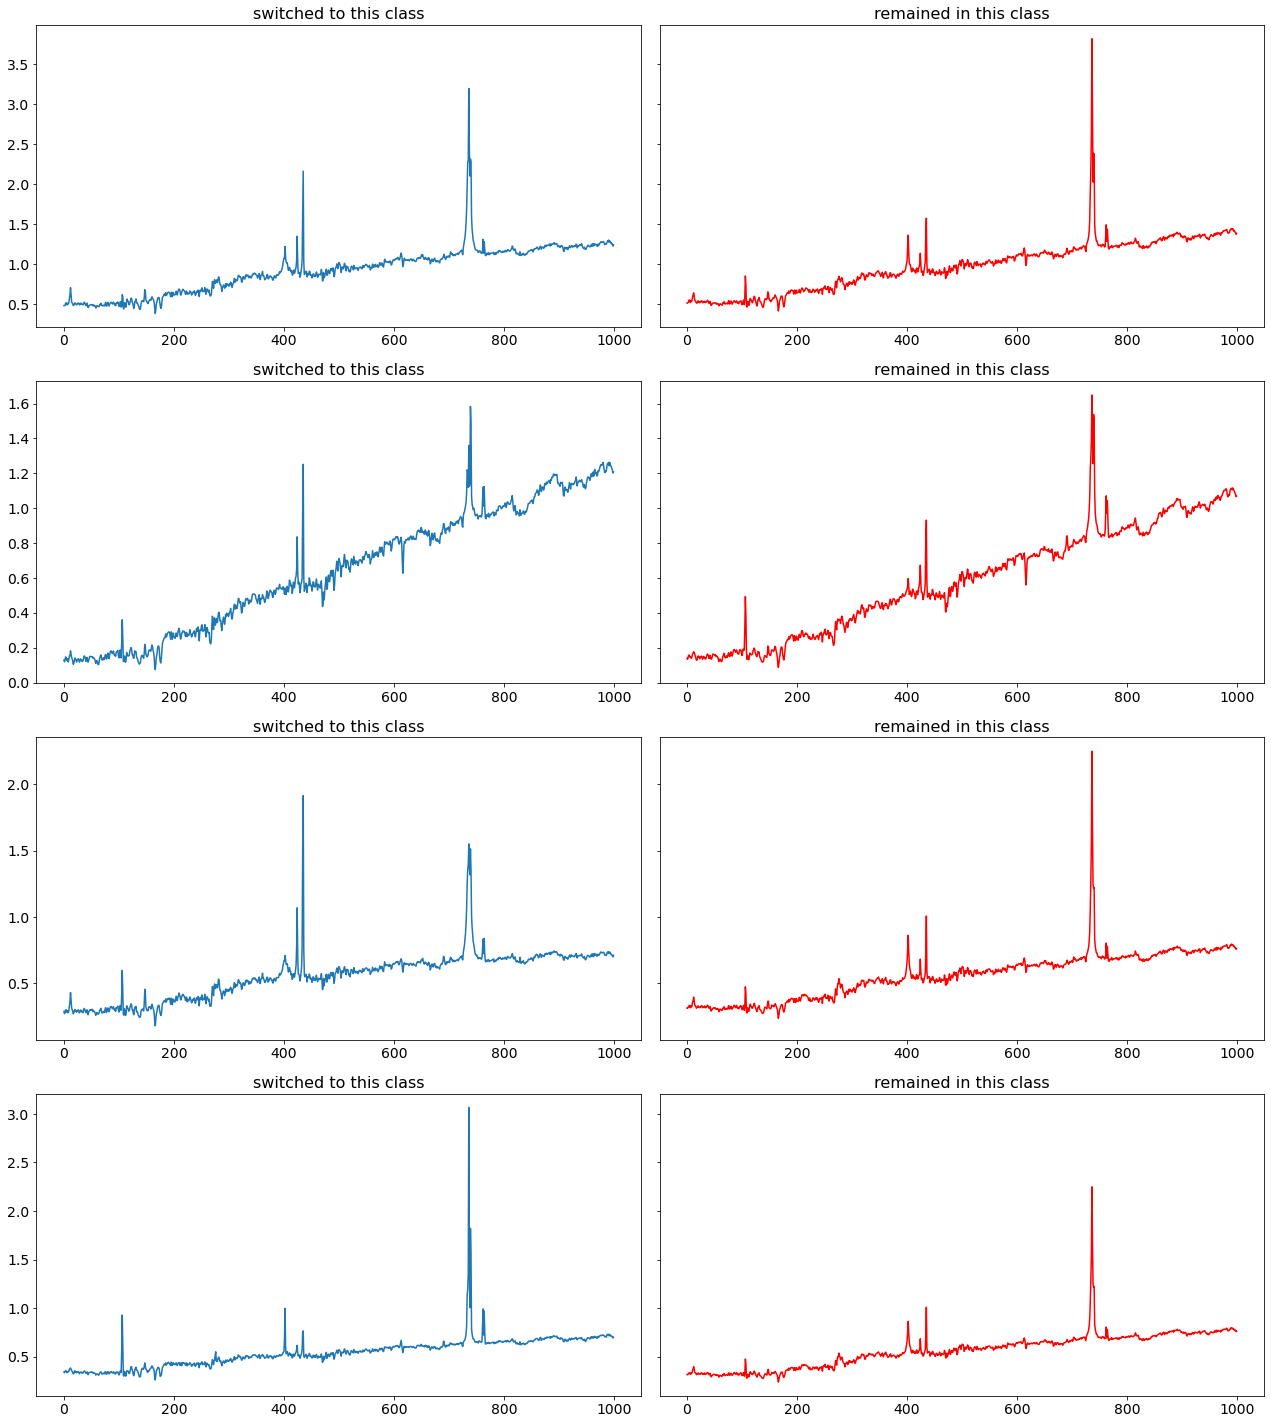

In [48]:
for jj in range(16):
    print(le[jj])
    enc              = encoded_train[(train['new_inf_labels']!=jj)&(train['new_label']==jj)]
    dist, neighbors = trees[jj].query(enc, p=1)
    num = 4
    fi, ax = plt.subplots(num,2,figsize=(18,20),sharey='row')
    ax = ax.flatten()
    count =0
    for ii in range(num):
        ax[count].set_title('switched to this class')
        ax[count].plot(decoded['train'][(train['new_inf_labels']!=jj)&(train['new_label']==jj)][ii])
        #ax[count].legend()
        count+=1
        ax[count].set_title('remained in this class')
        ax[count].plot(decoded['train'][(train['new_inf_labels']==jj)&(train['new_label']==jj)][neighbors[ii]], color='red', label='dist %.2f'%(dist[ii]))
        #ax[count].legend()
        count+=1

    plt.tight_layout()
    plt.show()

In [49]:
pickle.dump([train,valid,test,le],open(os.path.join(root_model_data,'combined_%s_new_relabeled.pkl'%label_),'wb'))

In [50]:
import sklearn.metrics as metrics

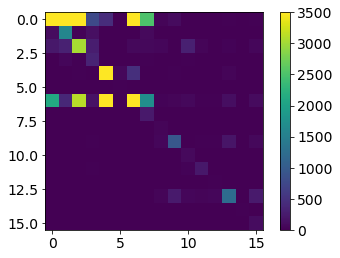

In [51]:
conf = metrics.confusion_matrix(train['new_inf_labels'], train['new_label'])
plt.imshow(conf, vmax=3500)
plt.colorbar()#, labels=le.inverse_transform(label))